# Multiclass Classification of Fashion-MNIST dataset with Pytorch
## Part-2: Implementing Regularization

In [ ]:
!pip install torchmetrics --quiet

     |████████████████████████████████| 419 kB 7.9 MB/s 


In [ ]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    gdrive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', gdrive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(gdrive_path, "Colab Notebooks","Pytorch")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        print('You Colab notebooks are available at ', COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(COLAB_NOTEBOOKS_PATH, "model_states")
        #IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    #IMAGES_ZIP_DIR = "./images/kaggle/malaria"

print(f"Model states will be saved to {MODEL_SAVE_DIR}")
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/Pytorch
NOTE: /content/drive/My Drive/Colab Notebooks/Pytorch is appended to sys.path!
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


## Standard Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook', font_scale=1.2)

# Pytorch imports
import torch
print(f'Using Pytorch version {torch.__version__}. ' + 
      f'GPU {"is available :)" if torch.cuda.is_available() else "is not available :("}')
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torchsummary import summary
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

# to ensure that you get consistent results across runs & machines
# @see: https://discuss.pytorch.org/t/reproducibility-over-different-machines/63047
# SEED = 41
# random.seed(SEED)
# os.environ['PYTHONHASHSEED'] = str(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED);

# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     #torch.backends.cudnn.enabled = False
pytk.seed_all(41)

Using Pytorch version 1.11.0+cu113. GPU is available :)


## Helper Functions

In [ ]:
def load_data():
    """
    load the data using datasets API. We also split the test_dataset into 
    cross-val/test datasets using 80:20 ration
    """
    mean, std = 0.5, 0.5
    transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset =  datasets.FashionMNIST(root='./data', train=True, download=True,
                                   transform=transformations)

    print("No of training records: %d" % len(train_dataset))

    test_dataset = datasets.FashionMNIST('./data', train=False, download=True,
                                  transform=transformations)
    print("No of test records: %d" % len(test_dataset))

    # lets split the test dataset into val_dataset & test_dataset -> 8000:2000 records
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [8000, 2000])
    print("No of cross-val records: %d" % len(val_dataset))
    print("No of test records: %d" % len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [ ]:
def display_sample(sample_images, sample_labels, grid_shape=(10, 10), plot_title=None,
                   sample_predictions=None):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn')

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.10)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=(14, 10),
            gridspec_kw={"wspace": 0.05, "hspace": 0.35}, squeeze=True)  # 0.03, 0.25
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90) # 0.93

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys", interpolation='nearest')

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title(f"{FASHION_LABELS[sample_labels[image_index]]}")
                else:
                    pred_matches_actual = (
                                sample_labels[image_index] == sample_predictions[image_index])
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = '%s' % FASHION_LABELS[sample_predictions[image_index]]
                        title_color = 'g'
                    else:
                        # show title as actual/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[sample_labels[image_index]],
                                           FASHION_LABELS[sample_predictions[image_index]])
                        title_color = 'r'

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

In [ ]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

No of training records: 60000
No of test records: 10000
No of cross-val records: 8000
No of test records: 2000


images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


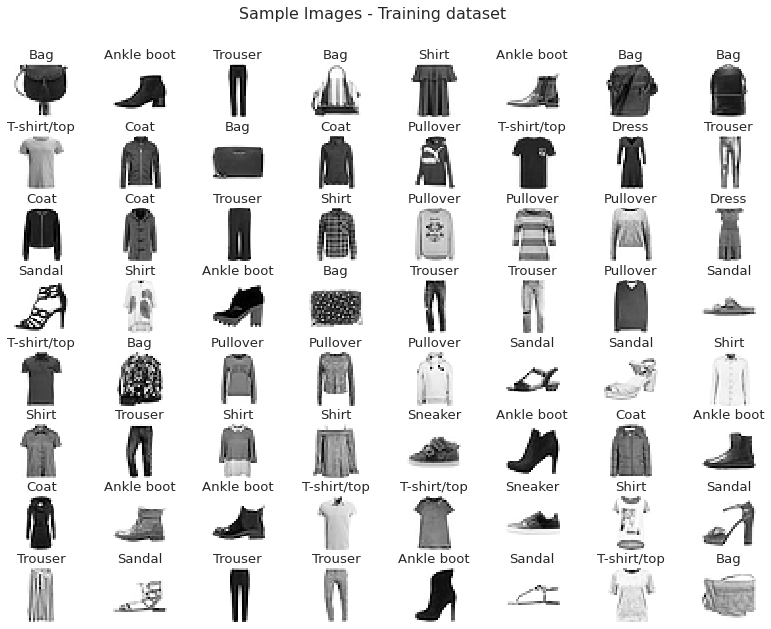

In [ ]:
# display a sample
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8), 
               plot_title='Sample Images - Training dataset')

## Pytorch Model development

In [ ]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 25, 128, 0.001, 0.0025
PY_MODEL_SAVE_PATH_L2 = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_l2.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_L2}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt


### Implementing L2 regularization 

In [ ]:
def build_model_l2():
    net = nn.Sequential(
        pytk.Conv2d(1, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        pytk.Conv2d(64, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(64, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        pytk.Conv2d(128, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(128, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        pytk.Conv2d(256, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # pytk.Conv2d(256, 512, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(512),
        # # pytk.Conv2d(512, 512, kernel_size=3, padding=1),
        # # nn.ReLU(),
        # # nn.BatchNorm2d(512),
        # nn.MaxPool2d(kernel_size=2, stride=2),
        # nn.Dropout(0.35),

        nn.Flatten(),

        nn.Linear(256*3*3, 1024),
        nn.ReLU(),

        nn.Linear(1024, 512),
        nn.ReLU(),

        nn.Linear(512, NUM_CLASSES)     
    )

    model = pytk.PytkModuleWrapper(net)
    loss_fn = nn.CrossEntropyLoss()
    # we add regularization to the optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [ ]:
model, optimizer = build_model_l2()
model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]               0
      BatchNorm2d-13          [-1, 128, 14, 14]             256
        MaxPool2d-14            [-1, 12

## Train the model

In [ ]:
hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, 
                         epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Training on GPU...
Training on 60000 samples, cross-validating on 8000 samples
Epoch ( 1/25): (60000/60000) -> loss: 0.3950 - acc: 0.8539 - val_loss: 0.3280 - val_acc: 0.8862 - lr: ['0.00100000']
Epoch ( 2/25): (60000/60000) -> loss: 0.3355 - acc: 0.8773 - val_loss: 0.3229 - val_acc: 0.8887 - lr: ['0.00100000']
Epoch ( 3/25): (60000/60000) -> loss: 0.3080 - acc: 0.8878 - val_loss: 0.3003 - val_acc: 0.8946 - lr: ['0.00100000']
Epoch ( 4/25): (60000/60000) -> loss: 0.2901 - acc: 0.8942 - val_loss: 0.2949 - val_acc: 0.8961 - lr: ['0.00100000']
Epoch ( 5/25): (60000/60000) -> loss: 0.2769 - acc: 0.8994 - val_loss: 0.2917 - val_acc: 0.8983 - lr: ['0.00100000']
Epoch ( 6/25): (60000/60000) -> loss: 0.2662 - acc: 0.9035 - val_loss: 0.2812 - val_acc: 0.9020 - lr: ['0.00100000']
Epoch ( 7/25): (60000/60000) -> loss: 0.2570 - acc: 0.9072 - val_loss: 0.2725 - val_acc: 0.9047 - lr: ['0.00100000']
Epoch ( 8/25): (60000/60000) -> loss: 0.2483 - acc: 0.9105 - val_loss: 0.2662 - val_acc: 0.9069 - lr: 

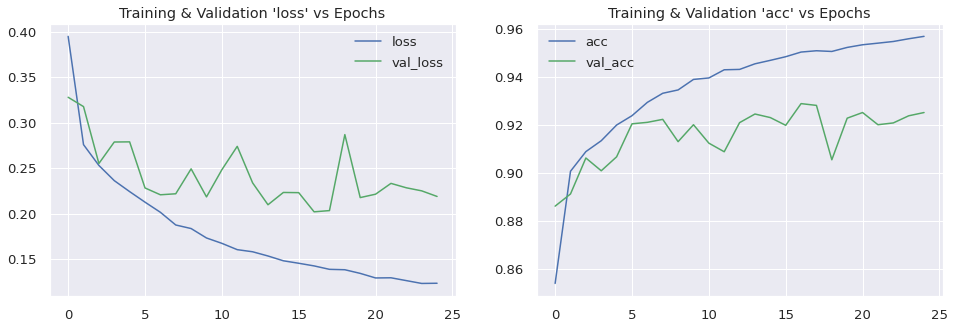

In [ ]:
pytk.show_plots(hist, metric='acc')

## Evaluate Performance

In [ ]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1014 - acc: 0.9669
  Training dataset -> loss: 0.1014 - acc: 0.9669
Evaluating (8000/8000) -> loss: 0.2186 - acc: 0.9254
  Cross-val dataset -> loss: 0.2186 - acc: 0.9254
Evaluating (2000/2000) -> loss: 0.2319 - acc: 0.9253
  Test dataset      -> loss: 0.2319 - acc: 0.9253


### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~99%|~93%|~93%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92%|~92-93%| Still Overfitting

From the table & graphs we observe that:
* Overfitting has reduced - from training accuracy of ~99%, it has come down to 96%, whereas the cross-val & test accuracies have not decreased that much.
* You will also observe from the plots that the curves do not diverge as much as they did previously.

The model is still overfitting, though less than before.

Next, we will explore another regularization technique used in deep learning - viz. **dropout regularization**.

In [ ]:
model.save(PY_MODEL_SAVE_PATH_L2)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt


## Making Predictions

In [ ]:
model, optimizer = build_model_l2()
model.load(PY_MODEL_SAVE_PATH_L2)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]    

In [ ]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 153/2000 incorrect!


Displaying sample predictions...


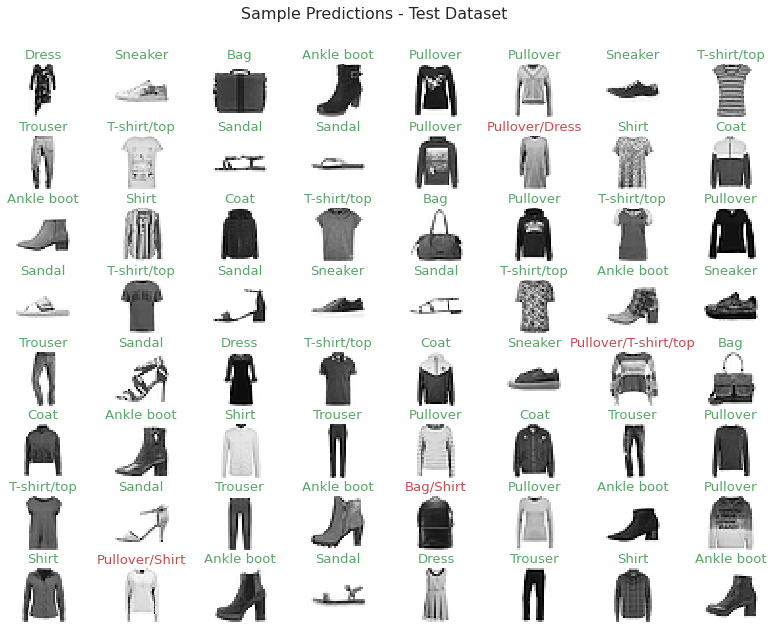

In [ ]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images, labels.cpu().numpy(), sample_predictions=preds,
                grid_shape=(8, 8), plot_title='Sample Predictions - Test Dataset')

## Observations
* The base model is significantly overfitting the data
* We get 153/2000 incorrect predictions from test dataset - this is worse than the base model (Base Model - 149/2000 incorrect). So I will definately not use this model.

## Implementing Dropout regularization

In [ ]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 25, 128, 0.001, 0.0025
PY_MODEL_SAVE_PATH_DO = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_do.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_DO}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_do.pyt


In [ ]:
def build_model_do():
    net = nn.Sequential(
        pytk.Conv2d(1, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        pytk.Conv2d(64, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.20),

        pytk.Conv2d(64, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        pytk.Conv2d(128, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.30),

        pytk.Conv2d(128, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        pytk.Conv2d(256, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.40),

        # pytk.Conv2d(256, 512, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(512),
        # # pytk.Conv2d(512, 512, kernel_size=3, padding=1),
        # # nn.ReLU(),
        # # nn.BatchNorm2d(512),
        # nn.MaxPool2d(kernel_size=2, stride=2),
        # nn.Dropout(0.35),

        nn.Flatten(),
        nn.Dropout(0.40),

        nn.Linear(256*3*3, 1024),
        nn.ReLU(),
        nn.Dropout(0.30),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.30),

        nn.Linear(512, NUM_CLASSES)     
    )

    model = pytk.PytkModuleWrapper(net)
    loss_fn = nn.CrossEntropyLoss()
    # we add regularization to the optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [ ]:
model, optimizer = build_model_do()
model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]         147,584
             ReLU-13          [-1, 128, 14, 14]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, 
                         epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Training on GPU...
Training on 60000 samples, cross-validating on 8000 samples
Epoch ( 1/25): (60000/60000) -> loss: 0.4846 - acc: 0.8226 - val_loss: 0.3664 - val_acc: 0.8682 - lr: ['0.00100000']
Epoch ( 2/25): (60000/60000) -> loss: 0.3965 - acc: 0.8556 - val_loss: 0.3228 - val_acc: 0.8846 - lr: ['0.00100000']
Epoch ( 3/25): (60000/60000) -> loss: 0.3524 - acc: 0.8720 - val_loss: 0.3143 - val_acc: 0.8878 - lr: ['0.00100000']
Epoch ( 4/25): (60000/60000) -> loss: 0.3247 - acc: 0.8825 - val_loss: 0.2929 - val_acc: 0.8952 - lr: ['0.00100000']
Epoch ( 5/25): (60000/60000) -> loss: 0.3042 - acc: 0.8901 - val_loss: 0.2772 - val_acc: 0.9004 - lr: ['0.00100000']
Epoch ( 6/25): (60000/60000) -> loss: 0.2883 - acc: 0.8961 - val_loss: 0.2675 - val_acc: 0.9040 - lr: ['0.00100000']
Epoch ( 7/25): (60000/60000) -> loss: 0.2752 - acc: 0.9008 - val_loss: 0.2600 - val_acc: 0.9071 - lr: ['0.00100000']
Epoch ( 8/25): (60000/60000) -> loss: 0.2639 - acc: 0.9050 - val_loss: 0.2531 - val_acc: 0.9103 - lr: 

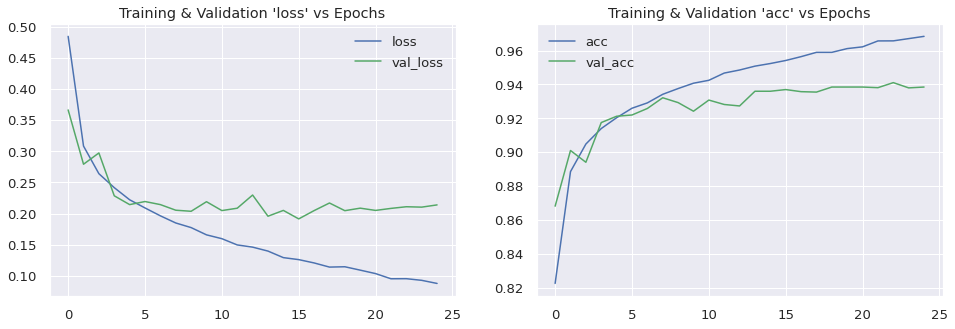

In [ ]:
pytk.show_plots(hist, metric='acc')

In [ ]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.0399 - acc: 0.9873
  Training dataset -> loss: 0.0399 - acc: 0.9873
Evaluating (8000/8000) -> loss: 0.2140 - acc: 0.9385
  Cross-val dataset -> loss: 0.2140 - acc: 0.9385
Evaluating (2000/2000) -> loss: 0.2293 - acc: 0.9385
  Test dataset      -> loss: 0.2293 - acc: 0.9385


### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~99%|~93%|~93%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92%|~92-93%| Still Overfitting
>**Base Model + Dropout regularization**|~98-99%|~93-94%|~93-94%| Overfitting

From the table & graphs we observe that:
* Seems to have similar performance as the base model
* L2 regularization had better performance that dropout in terms of controlling overfitting.

However, the model is still overfitting (lesser than before), but still overfitting. 

Next, let us implement both L2 & dropout regularization.

In [ ]:
model.save(PY_MODEL_SAVE_PATH_DO)
del model

In [ ]:
model, optimizer = build_model_do()
model.load(PY_MODEL_SAVE_PATH_DO)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

In [ ]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 126/2000 incorrect!


Displaying sample predictions...


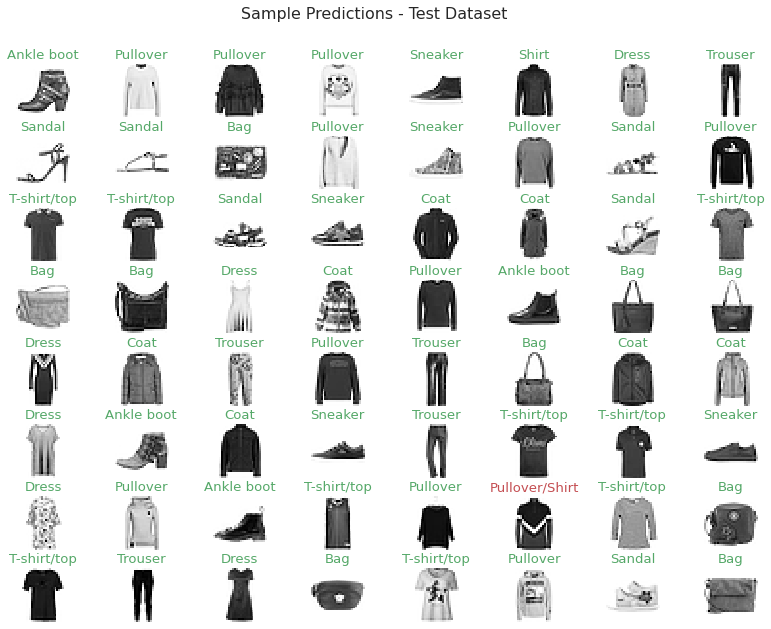

In [ ]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images, labels.cpu().numpy(), sample_predictions=preds,
                grid_shape=(8, 8), plot_title='Sample Predictions - Test Dataset')

## Combining L2  and dropout regularization

In this section, we'll combine both the techniques above to check performance of the model.

In [ ]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 35, 128, 0.001, 0.0010
PY_MODEL_SAVE_PATH_L2_DO = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_l2_do.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_L2_DO}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2_do.pyt


In [ ]:
def build_model_l2_do():
    net = nn.Sequential(
        pytk.Conv2d(1, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        pytk.Conv2d(64, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.20),

        pytk.Conv2d(64, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        pytk.Conv2d(128, 128, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.30),

        pytk.Conv2d(128, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        pytk.Conv2d(256, 256, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.40),

        # pytk.Conv2d(256, 512, kernel_size=3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(512),
        # # pytk.Conv2d(512, 512, kernel_size=3, padding=1),
        # # nn.ReLU(),
        # # nn.BatchNorm2d(512),
        # nn.MaxPool2d(kernel_size=2, stride=2),
        # nn.Dropout(0.35),

        nn.Flatten(),
        nn.Dropout(0.40),

        nn.Linear(256*3*3, 1024),
        nn.ReLU(),
        nn.Dropout(0.30),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.30),

        nn.Linear(512, NUM_CLASSES)     
    )

    model = pytk.PytkModuleWrapper(net)
    loss_fn = nn.CrossEntropyLoss()
    # we add regularization to the optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [ ]:
model, optimizer = build_model_l2_do()
model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]         147,584
             ReLU-13          [-1, 128, 14, 14]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
hist = model.fit_dataset(train_dataset, validation_dataset=val_dataset, 
                         epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Training on GPU...
Training on 60000 samples, cross-validating on 8000 samples
Epoch ( 1/35): (60000/60000) -> loss: 0.4692 - acc: 0.8289 - val_loss: 0.3680 - val_acc: 0.8683 - lr: ['0.00100000']
Epoch ( 2/35): (60000/60000) -> loss: 0.3889 - acc: 0.8594 - val_loss: 0.3213 - val_acc: 0.8860 - lr: ['0.00100000']
Epoch ( 3/35): (60000/60000) -> loss: 0.3520 - acc: 0.8728 - val_loss: 0.3071 - val_acc: 0.8912 - lr: ['0.00100000']
Epoch ( 4/35): (60000/60000) -> loss: 0.3304 - acc: 0.8810 - val_loss: 0.2936 - val_acc: 0.8961 - lr: ['0.00100000']
Epoch ( 5/35): (60000/60000) -> loss: 0.3146 - acc: 0.8871 - val_loss: 0.2843 - val_acc: 0.8985 - lr: ['0.00100000']
Epoch ( 6/35): (60000/60000) -> loss: 0.3024 - acc: 0.8917 - val_loss: 0.2770 - val_acc: 0.9010 - lr: ['0.00100000']
Epoch ( 7/35): (60000/60000) -> loss: 0.2940 - acc: 0.8948 - val_loss: 0.2703 - val_acc: 0.9037 - lr: ['0.00100000']
Epoch ( 8/35): (60000/60000) -> loss: 0.2863 - acc: 0.8976 - val_loss: 0.2649 - val_acc: 0.9058 - lr: 

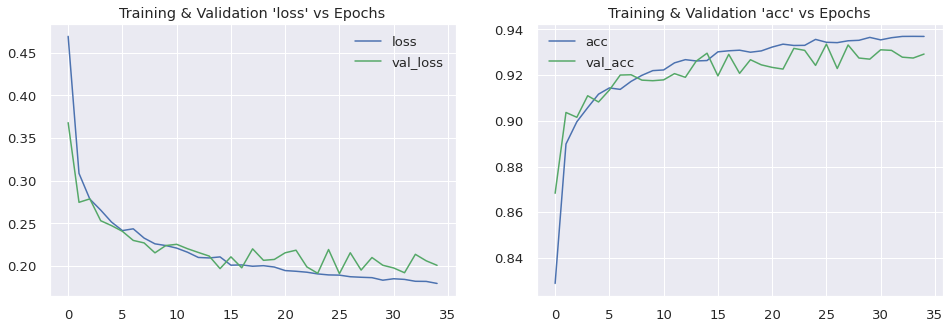

In [ ]:
pytk.show_plots(hist, metric='acc')

In [ ]:
# evaluate performance
print('Evaluating model performance...')
loss, acc = model.evaluate_dataset(train_dataset)
print(f'  Training dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(val_dataset)
print(f'  Cross-val dataset -> loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = model.evaluate_dataset(test_dataset)
print(f'  Test dataset      -> loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1283 - acc: 0.9551
  Training dataset -> loss: 0.1283 - acc: 0.9551
Evaluating (8000/8000) -> loss: 0.2008 - acc: 0.9293
  Cross-val dataset -> loss: 0.2008 - acc: 0.9293
Evaluating (2000/2000) -> loss: 0.2135 - acc: 0.9258
  Test dataset      -> loss: 0.2135 - acc: 0.9258


### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Base Model**|~99%|~93%|~93%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92%|~92-93%| Still Overfitting
>**Base Model + Dropout regularization**|~98-99%|~93-94%|~93-94%| Overfitting
>**Base Model + Dropout & L2 regularization**|~95-96%|~93%|92-93%| Overfitting has reduced.

You will notice that after implemention both L2 & dropout regularization, overall overfitting has reduced to approx ~ 2% (from ~ 6%) for training accuracies. The cross-val & test accuracies are at a level similar to the base model (~ 93%).

* We could try and train this model for many more epochs (say 50) as the loss + accuracy curves have not diverged much
* We could try with various values of L2-REG and dropout percentages to get the best model (iterative approach).
* We can inspect another technique, where we use pre-trained models.

In [ ]:
model.save(PY_MODEL_SAVE_PATH_L2_DO)
del model

In [ ]:
model, optimizer = build_model_l2_do()
model.load(PY_MODEL_SAVE_PATH_L2_DO)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

In [ ]:
# run predictions
y_pred, y_true = model.predict_dataset(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 152/2000 incorrect!


Displaying sample predictions...


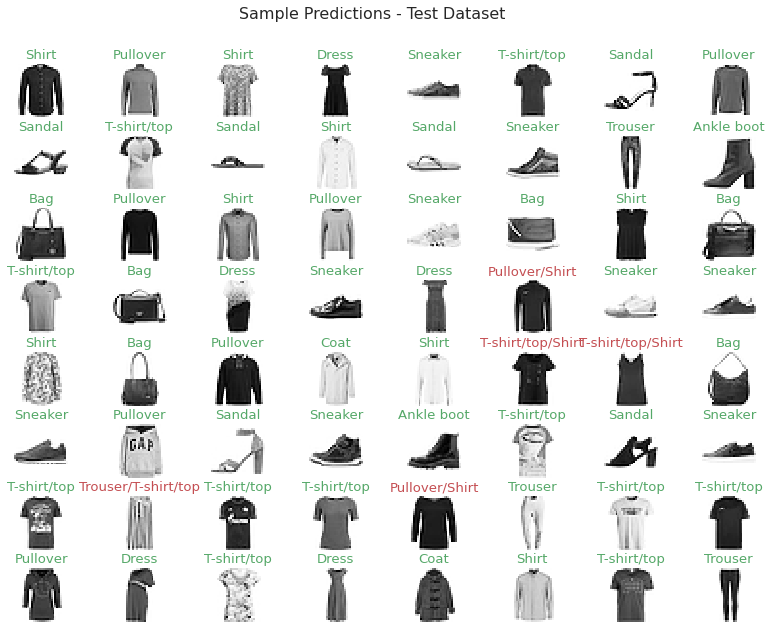

In [ ]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = data_iter.next()  # fetch a batch of 64 random images
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
#type(images), type(labels), type(preds)
display_sample(images, labels.cpu().numpy(), sample_predictions=preds,
                grid_shape=(8, 8), plot_title='Sample Predictions - Test Dataset')

# <center> -- END -- </center>